In [31]:
import os, random, copy
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [32]:
# ── Reproducibility ───────────────────────────────────────────────────────────
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

# ── Paths  (matches your existing EDA setup) ──────────────────────────────────
BASE_DIR = Path('..').resolve()
DATA_DIR = BASE_DIR / 'data' / 'raw'

splits = {
    'train':    DATA_DIR / 'train',
    'validate': DATA_DIR / 'validate',
    'test':     DATA_DIR / 'test',
}

Using device: cpu


## 1. EDA

In [33]:
def win_safe_loader(path: str):
    if os.name == 'nt' and not path.startswith('\\\\?\\'):
        path = '\\\\?\\' + path
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class SafeImageFolder(ImageFolder):
    def __init__(self, root, transform=None, **kwargs):
        super().__init__(root=root, transform=transform,
                         loader=win_safe_loader, **kwargs)

In [34]:
# 1. PATH SETUP (matches your folder layout)
# Your notebook is in: project/notebooks/  So go UP ONE LEVEL to reach the project root
# In computer-speak, .. means "go up one level." It refers to the parent folder of wherever your script or notebook is currently running.
#.resolve() forces Python to look at the actual address on your hard drive. It turns a relative path (like "one floor up") 
# into an Absolute Path (like C:\Users\glori\Documents\...).
BASE_DIR = Path("..").resolve()
DATA_DIR = BASE_DIR / "data" / "raw"

# A dictionary mapping each split name to its folder path. Using a dict instead of separate variables makes it easy to loop over later.
splits = {
    "train": DATA_DIR / "train",
    "validate": DATA_DIR / "validate",
    "test": DATA_DIR / "test"
}

# classes drives everything — the counting, totalling, and melting all reference it. rows will collect one dictionary per split, later turned into a DataFrame.
classes = ["edible", "poisonous"]
# a list of dictionaries. Each dictionary looked like {"split": "train", "edible": 1117, ...}. At this point, it’s just a long, messy list of text and numbers in Python's 
valid_extensions = {".jpg", ".jpeg", ".png"}
rows = []

for split, dir_path in splits.items():
    # Starts a new dictionary for this split. After the inner loop it will look like:
    # python{"split": "train", "edible": 240, "poisonous": 180, "total": 420}
    row = {"split": split}
    
    # .glob("*") returns a generator of Path objects, one for each file. Example output (conceptually): data/raw/train/edible/Ganoderma_lucidum_000020_1.jpg
    # sum(1 for ...) → counts the matches by adding 1 for each valid file (more memory efficient than building a full list with len([...]))
    for cls in classes:
        row[cls] = sum(1 for f in (dir_path / cls).glob("*") if f.suffix.lower() in valid_extensions)
        # So after the inner loop, row looks like:
        # python{"split": "train", "edible": 240, "poisonous": 180}

    # Adds up all class counts. Using classes here means if you add a third class, the total still works automatically.
    row["total"] = sum(row[c] for c in classes)
    # Adds the completed row dict to the list
    rows.append(row)

# a constructor from the Pandas library. It takes that list rows and automatically organizes it into a 2D grid (rows and columns).
df = pd.DataFrame(rows)
# When you type the name of a variable as the very last line in a code cell (especially in Jupyter Notebooks or VS Code), it tells Python to display or print the contents of that variable.
# Without this line, the DataFrame would be created silently in the background.
df

,split,edible,poisonous,total
0,train,1200,1056,2256
1,validate,150,132,282
2,test,150,132,282


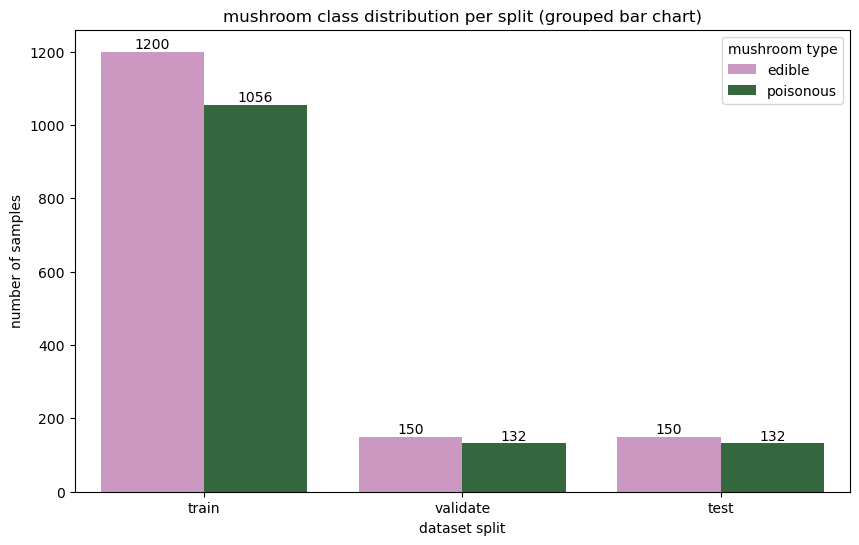

In [35]:
#BEFORE melt (wide)
#AFTER melt (long):
#split     mushroom type   number of samples
#train     edible          1200
#train     poisonous       1056
# standard pandas melt parameters/parameter names of the .melt() function. always called this.
# your DataFrame does NOT need to have columns with these names. they are just the arguments that tell pandas how to reshape your data.
df_melted = df.melt(
    id_vars='split', # Keep `split` column as-is. columns that should stay as they are. These columns are identifiers. 
    value_vars=classes, # columns that should be unpivoted into rows, turned into long format
    var_name='mushroom type', # The new column that holds the old column names
    value_name='number of samples' # The new column that holds the actual counts/values
)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_melted, x='split', y='number of samples', hue='mushroom type', palette='cubehelix_r')

for container in ax.containers:
    ax.bar_label(container)

plt.legend(title="mushroom type")
plt.title('mushroom class distribution per split (grouped bar chart)')
plt.xlabel('dataset split')
plt.ylabel('number of samples')
plt.show()

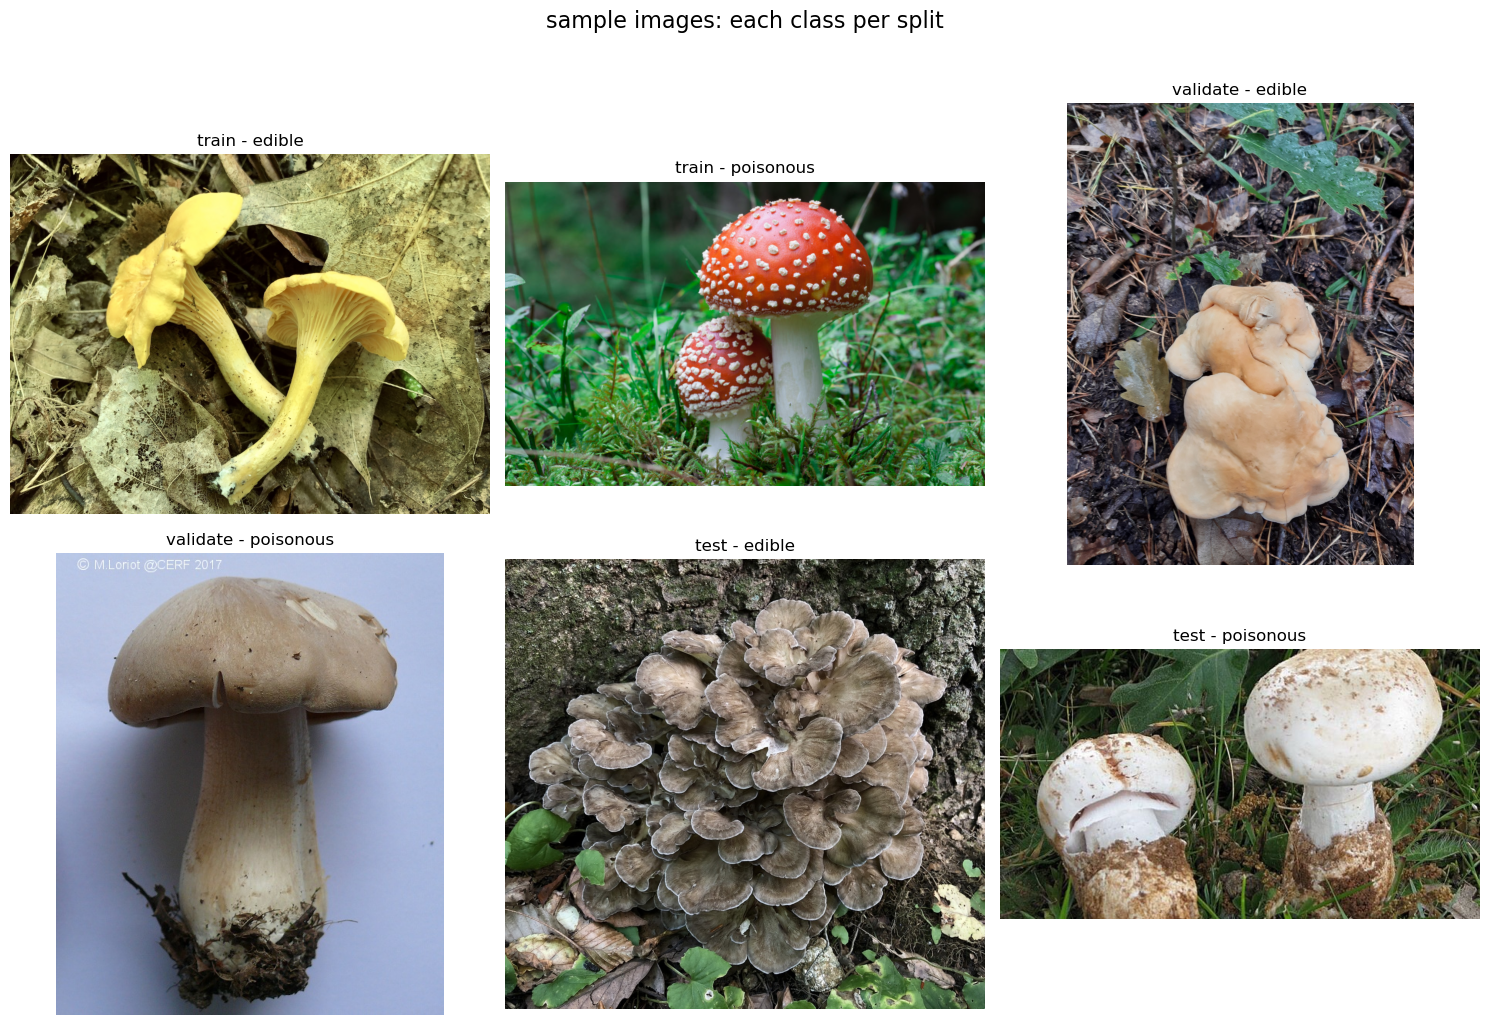

In [36]:
# set up the plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('sample images: each class per split', fontsize=16, y=1.02)

# flatten axes for easier indexing
axes_flat = axes.flatten()
# counter for subplot 
plot_idx = 0

# for each split and class, display a random sample image
for split, dir_path in splits.items():
    for cls in classes:
        # get all image files in the class folder
        class_path = dir_path / cls
        images = [f for f in class_path.glob("*") if f.suffix.lower() in valid_extensions]

        # select a random image
        if images:
            random_image = random.choice(images)
            # load and display the image. use the safe function here 
            img = safe_image_open(random_image) 
            axes_flat[plot_idx].imshow(img)
            axes_flat[plot_idx].set_title(f'{split} - {cls}', fontsize=12)
            axes_flat[plot_idx].axis('off')
        else:
            # Handle case with no images
            axes_flat[plot_idx].text(0.5, 0.5, f'No images\nin {split}/{cls}', 
                                   ha='center', va='center')
            axes_flat[plot_idx].set_title(f'{split} - {cls}', fontsize=12)
            axes_flat[plot_idx].axis('off')

        plot_idx += 1

plt.tight_layout()
plt.show()

## 2. Shared Training Engine
One reusable function used for **both** the Baseline CNN and Transfer Learning.

**What this combines from all versions:**
- `tqdm` progress bars with live loss/acc (Doc 5)
- `copy.deepcopy` best-model checkpointing — restores best weights at end (Doc 5)
- `finetune_epoch` auto-switch inside the loop (Doc 5)
- Differential learning rates for backbone vs head during fine-tuning (my improvement)
- 85% target line + fine-tune vertical line on accuracy plot (Docs 4 & 5)

In [37]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                scheduler=None, num_epochs=15, finetune_epoch=None,
                finetune_layers=('layer4', 'fc'), finetune_lr=1e-4):
    """
    Universal training loop.

    Parameters
    ----------
    finetune_epoch  : int or None  — epoch index at which to unfreeze layers
    finetune_layers : tuple        — layer name substrings to unfreeze
    finetune_lr     : float        — LR for backbone; head gets 10x this value
    """
    history = {'train_loss': [], 'val_loss': [],
               'train_acc':  [], 'val_acc':  []}
    best_val_acc = 0.0
    best_weights = copy.deepcopy(model.state_dict())
    best_preds, best_labels = [], []

    for epoch in range(num_epochs):

        # ── Phase switch: unfreeze layers & apply differential LRs ───────────
        if finetune_epoch and epoch == finetune_epoch:
            print(f'\n{"="*55}')
            print(f'  Epoch {epoch+1}: SWITCHING TO FINE-TUNE — unfreezing {finetune_layers}')
            print(f'{"="*55}\n')
            for name, param in model.named_parameters():
                if any(layer in name for layer in finetune_layers):
                    param.requires_grad = True
            # Differential LRs: backbone gets small LR to protect pretrained features
            # head gets 10x larger LR because it is newly initialised
            backbone_params = [p for n, p in model.named_parameters()
                               if p.requires_grad and 'fc' not in n]
            head_params     = [p for n, p in model.named_parameters()
                               if p.requires_grad and 'fc' in n]
            optimizer = optim.Adam([
                {'params': backbone_params, 'lr': finetune_lr},
                {'params': head_params,     'lr': finetune_lr * 10},
            ])

        # ── Training phase ───────────────────────────────────────────────────
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1:02d}/{num_epochs} [Train]')
        for imgs, labels in train_bar:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total   += imgs.size(0)
            train_bar.set_postfix(loss=f'{loss.item():.4f}',
                                  acc=f'{100*correct/total:.1f}%')

        epoch_train_loss = running_loss / total
        epoch_train_acc  = 100 * correct / total

        # ── Validation phase ─────────────────────────────────────────────────
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        epoch_preds, epoch_labels = [], []

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1:02d}/{num_epochs} [Val]  ')
            for imgs, labels in val_bar:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                loss    = criterion(outputs, labels)

                val_loss += loss.item() * imgs.size(0)
                _, preds = outputs.max(1)
                correct += preds.eq(labels).sum().item()
                total   += imgs.size(0)
                epoch_preds.extend(preds.cpu().numpy())
                epoch_labels.extend(labels.cpu().numpy())
                val_bar.set_postfix(loss=f'{loss.item():.4f}',
                                    acc=f'{100*correct/total:.1f}%')

        epoch_val_loss = val_loss / total
        epoch_val_acc  = 100 * correct / total

        if scheduler:
            scheduler.step()

        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        print(f'Epoch {epoch+1:02d}/{num_epochs}  '
              f'Train Loss: {epoch_train_loss:.4f}  Acc: {epoch_train_acc:.2f}%  |  '
              f'Val Loss: {epoch_val_loss:.4f}  Acc: {epoch_val_acc:.2f}%')

        # ── Best-model checkpoint ────────────────────────────────────────────
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_weights = copy.deepcopy(model.state_dict())
            best_preds, best_labels = epoch_preds[:], epoch_labels[:]
            print(f'  ★ New best model saved  (Val Acc: {best_val_acc:.2f}%)')

    model.load_state_dict(best_weights)   # restore best weights
    return model, history, best_preds, best_labels


def plot_curves(history, title='Training Curves', finetune_epoch=None):
    """Loss & accuracy curves with 85% target line and optional fine-tune marker."""
    epochs = range(1, len(history['train_loss']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(epochs, history['train_loss'], 'o-', label='Train Loss')
    ax1.plot(epochs, history['val_loss'],   'o-', label='Val Loss')
    ax1.set(title='Loss', xlabel='Epoch', ylabel='Loss')
    ax1.legend(); ax1.grid(True)

    ax2.plot(epochs, history['train_acc'], 'o-', label='Train Acc')
    ax2.plot(epochs, history['val_acc'],   'o-', label='Val Acc')
    ax2.axhline(y=85, color='red', linestyle='--', label='85% target')     # from Doc 4
    if finetune_epoch is not None:
        ax2.axvline(x=finetune_epoch + 1, color='orange',
                    linestyle='--', label='Fine-tune start')                # from Doc 5
    ax2.set(title='Accuracy (%)', xlabel='Epoch', ylabel='Accuracy (%)')
    ax2.legend(); ax2.grid(True)

    fig.suptitle(title, fontsize=13)
    plt.tight_layout()
    plt.show()

## 3. Baseline CNN
Target: ~60–70% val accuracy — just proving the problem is learnable.

In [38]:
# ── Transforms (128x128, light augmentation) ──────────────────────────────────
baseline_train_tf = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
baseline_val_tf = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_ds_base = SafeImageFolder(root=str(splits['train']),    transform=baseline_train_tf)
val_ds_base   = SafeImageFolder(root=str(splits['validate']), transform=baseline_val_tf)
print(f'Classes: {train_ds_base.classes}')
print(f'Train: {len(train_ds_base):,}  |  Val: {len(val_ds_base):,}')

train_dl_base = DataLoader(train_ds_base, batch_size=32, shuffle=True,  num_workers=0)
val_dl_base   = DataLoader(val_ds_base,   batch_size=32, shuffle=False, num_workers=0)

Classes: ['edible', 'poisonous']
Train: 2,256  |  Val: 282


Epoch 01/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 01/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 01/15  Train Loss: 1.9924  Acc: 55.27%  |  Val Loss: 0.6309  Acc: 67.02%
  ★ New best model saved  (Val Acc: 67.02%)


Epoch 02/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 02/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 02/15  Train Loss: 0.6485  Acc: 60.73%  |  Val Loss: 0.6179  Acc: 66.31%


Epoch 03/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 03/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 03/15  Train Loss: 0.6441  Acc: 60.55%  |  Val Loss: 0.6258  Acc: 68.79%
  ★ New best model saved  (Val Acc: 68.79%)


Epoch 04/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 04/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 04/15  Train Loss: 0.6463  Acc: 59.35%  |  Val Loss: 0.6203  Acc: 67.73%


Epoch 05/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 05/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 05/15  Train Loss: 0.6424  Acc: 61.66%  |  Val Loss: 0.5949  Acc: 69.15%
  ★ New best model saved  (Val Acc: 69.15%)


Epoch 06/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 06/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 06/15  Train Loss: 0.6252  Acc: 63.56%  |  Val Loss: 0.6076  Acc: 65.96%


Epoch 07/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 07/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 07/15  Train Loss: 0.6180  Acc: 63.21%  |  Val Loss: 0.6008  Acc: 68.79%


Epoch 08/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 08/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 08/15  Train Loss: 0.6079  Acc: 65.47%  |  Val Loss: 0.5957  Acc: 67.73%


Epoch 09/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 09/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 09/15  Train Loss: 0.6091  Acc: 65.56%  |  Val Loss: 0.5880  Acc: 66.67%


Epoch 10/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 10/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/15  Train Loss: 0.5936  Acc: 66.13%  |  Val Loss: 0.6041  Acc: 65.25%


Epoch 11/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 11/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/15  Train Loss: 0.5811  Acc: 67.82%  |  Val Loss: 0.5738  Acc: 68.79%


Epoch 12/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 12/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/15  Train Loss: 0.5718  Acc: 67.69%  |  Val Loss: 0.5840  Acc: 69.50%
  ★ New best model saved  (Val Acc: 69.50%)


Epoch 13/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 13/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/15  Train Loss: 0.5661  Acc: 67.60%  |  Val Loss: 0.5582  Acc: 69.50%


Epoch 14/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 14/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/15  Train Loss: 0.5593  Acc: 69.68%  |  Val Loss: 0.5484  Acc: 72.70%
  ★ New best model saved  (Val Acc: 72.70%)


Epoch 15/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 15/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/15  Train Loss: 0.5488  Acc: 70.08%  |  Val Loss: 0.5877  Acc: 68.09%


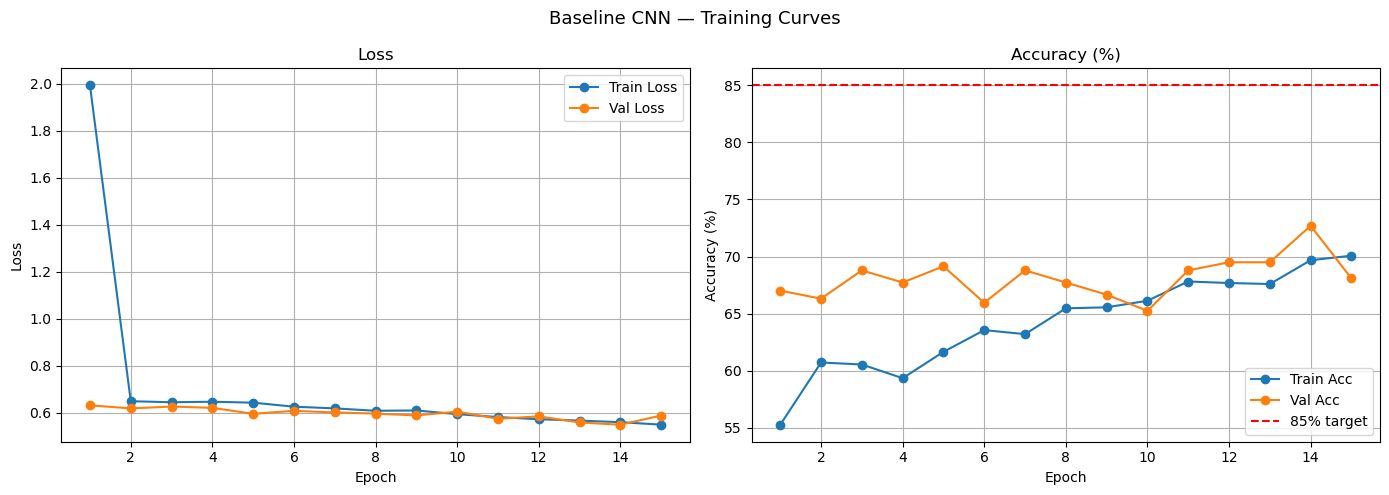

Baseline CNN — Best Val Accuracy: 72.70%


In [39]:
class BaselineCNN(nn.Module):
    """
    3 conv blocks: Conv -> BatchNorm -> ReLU -> MaxPool
    128x128 -> 64x64 -> 32x32 -> 16x16 feature maps, then FC head.
    """
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,  32, 3, padding=1), nn.BatchNorm2d(32),  nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64),  nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3), nn.Linear(128*16*16, 256), nn.ReLU(),
            nn.Dropout(0.3), nn.Linear(256, num_classes),
        )

    def forward(self, x):
        return self.classifier(self.features(x))


baseline_model = BaselineCNN().to(DEVICE)

criterion_b = nn.CrossEntropyLoss()
optimizer_b = optim.Adam(baseline_model.parameters(), lr=1e-3)
scheduler_b = optim.lr_scheduler.StepLR(optimizer_b, step_size=5, gamma=0.5)

baseline_model, history_base, _, _ = train_model(
    baseline_model, train_dl_base, val_dl_base,
    criterion_b, optimizer_b, scheduler_b,
    num_epochs=15
)

plot_curves(history_base, title='Baseline CNN — Training Curves')
print(f'Baseline CNN — Best Val Accuracy: {max(history_base["val_acc"]):.2f}%')

In [40]:
# ── Transforms (224x224, heavy augmentation) ──────────────────────────────────
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

tl_train_tf = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
tl_val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_ds_tl = SafeImageFolder(root=str(splits['train']),    transform=tl_train_tf)
val_ds_tl   = SafeImageFolder(root=str(splits['validate']), transform=tl_val_tf)
CLASS_NAMES  = train_ds_tl.classes
print(f'Classes: {CLASS_NAMES}  |  Train: {len(train_ds_tl):,}  |  Val: {len(val_ds_tl):,}')

train_dl_tl = DataLoader(train_ds_tl, batch_size=32, shuffle=True,  num_workers=0)
val_dl_tl   = DataLoader(val_ds_tl,   batch_size=32, shuffle=False, num_workers=0)

Classes: ['edible', 'poisonous']  |  Train: 2,256  |  Val: 282


In [41]:
# ── Load ResNet18 with correct modern API (pretrained=True is deprecated) ─────
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for param in resnet.parameters():       # freeze entire backbone
    param.requires_grad = False

# Replace head: 512 features -> dropout -> 256 -> 2 classes
resnet.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(resnet.fc.in_features, 256), nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2)
)
resnet = resnet.to(DEVICE)

trainable = sum(p.numel() for p in resnet.parameters() if p.requires_grad)
total     = sum(p.numel() for p in resnet.parameters())
print(f'Initially trainable: {trainable:,} / {total:,} ({100*trainable/total:.1f}%)')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\glori/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:04<00:00, 9.43MB/s]


Initially trainable: 131,842 / 11,308,354 (1.2%)


Epoch 01/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 01/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 01/15  Train Loss: 0.6684  Acc: 60.02%  |  Val Loss: 0.5114  Acc: 75.89%
  ★ New best model saved  (Val Acc: 75.89%)


Epoch 02/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 02/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 02/15  Train Loss: 0.5904  Acc: 68.93%  |  Val Loss: 0.4792  Acc: 76.24%
  ★ New best model saved  (Val Acc: 76.24%)


Epoch 03/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 03/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 03/15  Train Loss: 0.5791  Acc: 69.68%  |  Val Loss: 0.4808  Acc: 78.72%
  ★ New best model saved  (Val Acc: 78.72%)


Epoch 04/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 04/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 04/15  Train Loss: 0.5607  Acc: 71.05%  |  Val Loss: 0.4369  Acc: 80.50%
  ★ New best model saved  (Val Acc: 80.50%)


Epoch 05/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 05/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 05/15  Train Loss: 0.5644  Acc: 70.08%  |  Val Loss: 0.4520  Acc: 82.98%
  ★ New best model saved  (Val Acc: 82.98%)


Epoch 06/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 06/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 06/15  Train Loss: 0.5489  Acc: 70.48%  |  Val Loss: 0.4364  Acc: 82.62%


Epoch 07/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 07/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 07/15  Train Loss: 0.5346  Acc: 71.68%  |  Val Loss: 0.4283  Acc: 80.50%


Epoch 08/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 08/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 08/15  Train Loss: 0.5390  Acc: 71.41%  |  Val Loss: 0.4230  Acc: 82.27%

  Epoch 9: SWITCHING TO FINE-TUNE — unfreezing ('layer4', 'fc')



Epoch 09/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 09/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 09/15  Train Loss: 0.4993  Acc: 75.09%  |  Val Loss: 0.3244  Acc: 85.82%
  ★ New best model saved  (Val Acc: 85.82%)


Epoch 10/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 10/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/15  Train Loss: 0.3529  Acc: 83.47%  |  Val Loss: 0.3356  Acc: 84.04%


Epoch 11/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 11/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/15  Train Loss: 0.2730  Acc: 88.39%  |  Val Loss: 0.2245  Acc: 89.72%
  ★ New best model saved  (Val Acc: 89.72%)


Epoch 12/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 12/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/15  Train Loss: 0.2186  Acc: 90.20%  |  Val Loss: 0.1633  Acc: 92.91%
  ★ New best model saved  (Val Acc: 92.91%)


Epoch 13/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 13/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/15  Train Loss: 0.1691  Acc: 93.40%  |  Val Loss: 0.1951  Acc: 89.72%


Epoch 14/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 14/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/15  Train Loss: 0.1576  Acc: 94.50%  |  Val Loss: 0.1566  Acc: 93.26%
  ★ New best model saved  (Val Acc: 93.26%)


Epoch 15/15 [Train]:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 15/15 [Val]  :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/15  Train Loss: 0.1333  Acc: 94.73%  |  Val Loss: 0.1155  Acc: 95.39%
  ★ New best model saved  (Val Acc: 95.39%)


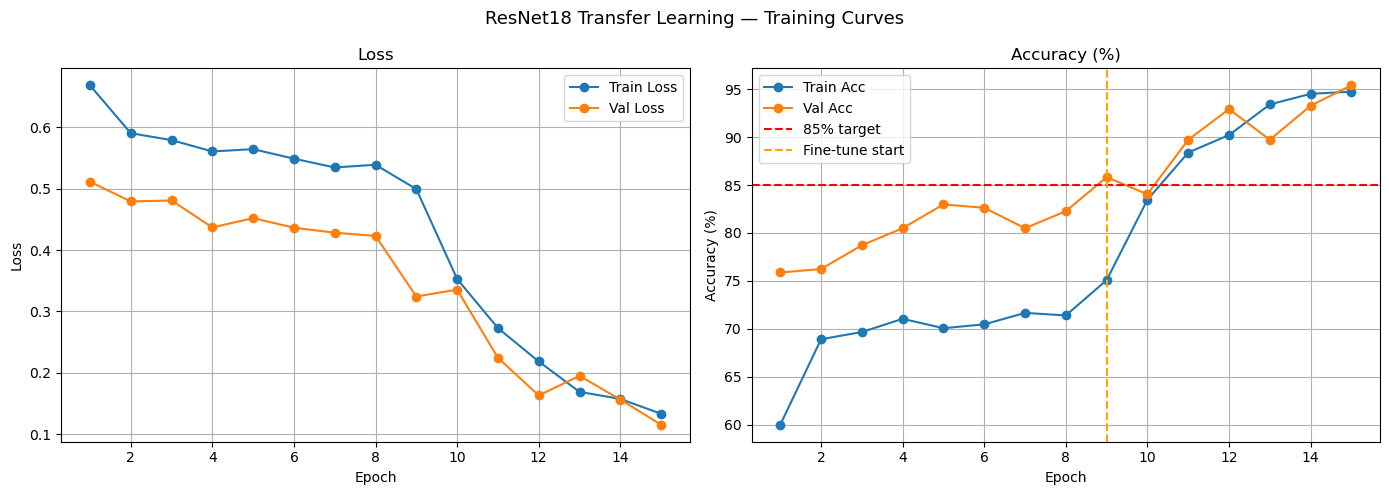

ResNet18 — Best Val Accuracy: 95.39%
✅ SUCCESS: Validation accuracy exceeds 85% target!


In [42]:
# ── Train: Phase A (head only) then auto Phase B (layer4 + head) ─────────────
FINETUNE_EPOCH = 8   # at this epoch, layer4 unfreezes with differential LRs

criterion_tl = nn.CrossEntropyLoss()
optimizer_tl = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=1e-3)
scheduler_tl = optim.lr_scheduler.StepLR(optimizer_tl, step_size=5, gamma=0.3)

resnet, history_tl, best_preds, best_labels = train_model(
    resnet, train_dl_tl, val_dl_tl,
    criterion_tl, optimizer_tl, scheduler_tl,
    num_epochs=15,
    finetune_epoch=FINETUNE_EPOCH,    # auto-switch inside the loop
    finetune_layers=('layer4', 'fc'), # what to unfreeze
    finetune_lr=1e-4                  # backbone LR; head gets 1e-3
)

plot_curves(history_tl,
            title='ResNet18 Transfer Learning — Training Curves',
            finetune_epoch=FINETUNE_EPOCH)

best_val = max(history_tl['val_acc'])
print(f'ResNet18 — Best Val Accuracy: {best_val:.2f}%')
if best_val >= 85:
    print('✅ SUCCESS: Validation accuracy exceeds 85% target!')
else:
    print(f'⚠️  {best_val:.2f}% is below 85%. Try:')
    print('   • Increase num_epochs to 20')
    print('   • Lower finetune_epoch to 5 (unfreeze earlier)')
    print('   • Add transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))')

## 5. Evaluation — Confusion Matrix & Classification Report

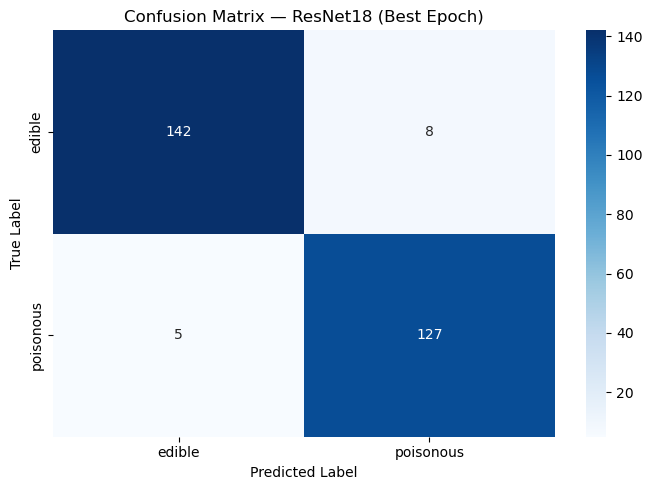

              precision    recall  f1-score   support

      edible       0.97      0.95      0.96       150
   poisonous       0.94      0.96      0.95       132

    accuracy                           0.95       282
   macro avg       0.95      0.95      0.95       282
weighted avg       0.95      0.95      0.95       282



In [43]:
cm = confusion_matrix(best_labels, best_preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix — ResNet18 (Best Epoch)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(classification_report(best_labels, best_preds, target_names=CLASS_NAMES))

## 6. Discussion & Model Comparison

In [44]:
print('='*55)
print('MODEL COMPARISON')
print('='*55)
print(f'Baseline CNN  Best Val Acc : {max(history_base["val_acc"]):.2f}%')
print(f'ResNet18 TL   Best Val Acc : {max(history_tl["val_acc"]):.2f}%')
print()
print('Key takeaways:')
print('• Baseline CNN proves the problem is learnable (60-70%)')
print('• ResNet18 already knows edges/textures from 1.2M ImageNet images')
print('• Phase A (frozen backbone) = fast early gains with low risk')
print('• Phase B (unfreeze layer4) = fine-tunes mushroom-specific features')
print('• Differential LRs protect pretrained weights during fine-tuning')
print('• Heavy augmentation (flip, rotate, color jitter, crop) reduces overfitting')
print('• copy.deepcopy checkpointing ensures we return the best epoch, not the last')

# Save model
torch.save(resnet.state_dict(), 'resnet18_mushroom_best.pth')
print('\nModel saved -> resnet18_mushroom_best.pth')

MODEL COMPARISON
Baseline CNN  Best Val Acc : 72.70%
ResNet18 TL   Best Val Acc : 95.39%

Key takeaways:
• Baseline CNN proves the problem is learnable (60-70%)
• ResNet18 already knows edges/textures from 1.2M ImageNet images
• Phase A (frozen backbone) = fast early gains with low risk
• Phase B (unfreeze layer4) = fine-tunes mushroom-specific features
• Differential LRs protect pretrained weights during fine-tuning
• Heavy augmentation (flip, rotate, color jitter, crop) reduces overfitting
• copy.deepcopy checkpointing ensures we return the best epoch, not the last

Model saved -> resnet18_mushroom_best.pth
